## Importar librerias necesarias

In [ ]:
from abc import ABC, abstractmethod
import numpy as np
from os import urandom
import random
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from math import comb
from typing import List, Tuple, Optional
from collections import defaultdict

## Clase del cipher

In [ ]:
class Speck:
    def __init__(self, n_rounds=22, word_size=16, use_key_schedule=True, alpha=7, beta=2, m=4):
        self.n_rounds = int(n_rounds)
        self.word_size = int(word_size)
        self.n_words = 2
        self.n_main_key_words = int(m)
        self.n_round_key_words = 1
        self.use_key_schedule = bool(use_key_schedule)
        self.alpha = int(alpha)
        self.beta  = int(beta)
        self.mask_val = (1 << self.word_size) - 1
        # tipos (compat con np):
        self.main_key_word_dtype = np.uint16 if self.word_size == 16 else np.uint32
        self.round_keys = None  # np.array shape (R,1) con palabras de subllave

    # --- Rotaciones ---
    def rol(self, x, r):
        n = self.word_size
        return ((x << r) & ((1 << n) - 1)) | (x >> (n - r))

    def ror(self, x, r):
        n = self.word_size
        return (x >> r) | ((x << (self.word_size - r)) & ((1 << self.word_size) - 1))

    # --- Paridad ---
    @staticmethod
    def parity(x: int) -> int:
        return int(x).bit_count() & 1

    # ============ Ronda ============
    def encrypt_one_round(self, p, k, rc=None):
        """Una ronda: (x,y) -> (x',y'). k es [kw] o (kw,)."""
        x, y = int(p[0]), int(p[1])
        x = self.ror(x, self.alpha)
        x = (x + y) & self.mask_val
        x = x ^ int(k[0])
        y = self.rol(y, self.beta)
        y = y ^ x
        return x, y

    def decrypt_one_round(self, c, k, rc=None):
        """Inversa de una ronda: (x',y') -> (x,y)."""
        x, y = int(c[0]), int(c[1])
        y = y ^ x
        y = self.ror(y, self.beta)
        x = x ^ int(k[0])
        x = (x - y) & self.mask_val
        x = self.rol(x, self.alpha)
        return x, y

    # ============ Full/Reducido ============
    def encrypt(self, plaintext, rounds=None, key=None, trace=False):
        R = self.n_rounds if rounds is None else int(rounds)
        x, y = int(plaintext[0]), int(plaintext[1])
        rk = self.key_schedule(key) if (key is not None) else self.round_keys
        if rk is None:
            raise ValueError("round_keys no inicializadas. Llama key_schedule(key) o pasa key=")
        out = [(x, y)] if trace else None
        for r in range(R):
            x, y = self.encrypt_one_round((x, y), rk[r])
            if trace:
                out.append((x, y))
        return out if trace else (x, y)

    def decrypt(self, ciphertext, rounds=None, key=None, trace=False):
        R = self.n_rounds if rounds is None else int(rounds)
        x, y = int(ciphertext[0]), int(ciphertext[1])
        rk = self.key_schedule(key) if (key is not None) else self.round_keys
        if rk is None:
            raise ValueError("round_keys no inicializadas. Llama key_schedule(key) o pasa key=")
        rk = rk[:R]
        out = [(x, y)] if trace else None
        for r in range(R - 1, -1, -1):
            x, y = self.decrypt_one_round((x, y), rk[r])
            if trace:
                out.append((x, y))
        return out if trace else (x, y)

    # ============ Puntos internos última ronda ============
    def partial_decrypt_last_round(self, C, k_r, stop_at="before_add"):
        """
        Invierte selectivamente la última ronda sobre C=(x',y') usando k_r=[kw].
        stop_at:
          - "after_xor_y"     -> (x', y^)
          - "after_ror_beta"  -> (x', y~~)
          - "after_xor_k"     -> (x^, y~~)
          - "before_add"      -> (x~~, y~~)
          - "after_rol_alpha" -> (x, y) original antes de la última ronda
        """
        x1, y1 = int(C[0]), int(C[1])
        # y = y ^ x
        y = y1 ^ x1
        if stop_at == "after_xor_y":
            return x1, y
        # y = ROR(y, beta)
        y = self.ror(y, self.beta)
        if stop_at == "after_ror_beta":
            return x1, y
        # x = x ^ k
        x = x1 ^ int(k_r[0])
        if stop_at == "after_xor_k":
            return x, y
        # x = (x - y)
        x = (x - y) & self.mask_val
        if stop_at == "before_add":
            return x, y
        # x = ROL(x, alpha)
        x = self.rol(x, self.alpha)
        if stop_at == "after_rol_alpha":
            return x, y
        raise ValueError(f"stop_at desconocido: {stop_at}")

    # ============ Key schedule ============
    def key_schedule(self, key):
        """
        Devuelve np.array shape (n_rounds, 1) con las subllaves.
        'key' como np.array shape (m,1) o lista de m palabras.
        """
        if key is None:
            return self.round_keys
        if isinstance(key, (list, tuple)):
            key = np.array(key, dtype=self.main_key_word_dtype)[:, np.newaxis]
        assert key.shape[0] == self.n_main_key_words, "m (número de palabras de clave) no coincide"
        ks = [0 for _ in range(self.n_rounds)]
        ks[0] = int(key[len(key)-1][0])  # última palabra como k0
        L = list(reversed([int(key[i][0]) for i in range(len(key)-1)]))  # resto invertidas
        for i in range(self.n_rounds - 1):
            L[i % (len(L))], ks[i+1] = self.encrypt_one_round((L[i % len(L)], ks[i]), [i])
        self.round_keys = np.array(ks, dtype=self.main_key_word_dtype)[:, np.newaxis]
        return self.round_keys

    # ============ Correlación exacta de UNA suma (DP de carry) ============
    @staticmethod
    def _corr_addition(a_mask, b_mask, g_mask, n):
        # correlación exacta en [-1,1] para <a,x> ⊕ <b,y> ⊕ <g, x+y>
        A = [(a_mask>>i)&1 for i in range(n)]
        B = [(b_mask>>i)&1 for i in range(n)]
        G = [(g_mask>>i)&1 for i in range(n)]
        DP0, DP1 = 1, 0  # carry_in = 0/1
        for i in range(n):
            nDP0 = nDP1 = 0
            for cin in (0,1):
                base = DP0 if cin == 0 else DP1
                if base == 0:
                    continue
                for x in (0,1):
                    for y in (0,1):
                        cout = (x & y) | (x & cin) | (y & cin)
                        e = ((A[i]^G[i]) & x) ^ ((B[i]^G[i]) & y) ^ (G[i] & cin)
                        if cout == 0:
                            nDP0 += base if e == 0 else -base
                        else:
                            nDP1 += base if e == 0 else -base
            DP0, DP1 = nDP0, nDP1
        return (DP0 + DP1) / (2**(2*n))

    def corr_one_round_masks(self, ax, ay, gx, gy_prime=0):
        """
        Correlación de 1 ronda con máscaras (teórica):
        ax, ay: máscaras de entrada; gx: máscara en x' (XOR k no cambia corr);
        gy_prime: máscara en y' (opcional).
        """
        n = self.word_size
        a_for_adder = self.rol(ax, self.alpha)
        b_for_adder = ay ^ self.ror(gy_prime, self.beta)
        g_for_adder = gx
        return self._corr_addition(a_for_adder, b_for_adder, g_for_adder, n)

    # ===================================================
    #  (1) Herramientas manuales para triples (u,v,w)
    # ===================================================

    def corr_weight_add(self, u, v, w):
        """
        Devuelve Cw (entero) si (u,v,w) es válida para la suma n-bit; None si no lo es.
        Filtro de validez usa máscara Z (bits con acarreo).
        """
        n = self.word_size
        A = u ^ v
        B = u ^ w
        C = u ^ v ^ w
        cw = 0
        Z  = 0
        carry = 0
        for i in range(n):  # LSB→MSB
            cbit = (C >> i) & 1
            carry = (cbit + carry) & 1
            if carry:
                cw += 1
                Z |= (1 << i)
        if (A & ~Z) != 0:
            return None
        if (B & ~Z) != 0:
            return None
        return cw

    def next_round_masks(self, GX_i, GY_i, w):
        """
        Dadas GX_i, GY_i y elección de w = GX_{i+1}, produce:
          triple=(u,v,w)  y  siguiente estado (GX_{i+1}, GY_{i+1}).
        Reglas SPECK:
          u = ROR(GX_i, alpha),  v = GY_i,
          GY_{i+1} = ROL(GY_i, beta) ^ GX_{i+1}.
        """
        u = self.ror(GX_i, self.alpha)
        v = GY_i
        GX_ip1 = w
        GY_ip1 = self.rol(GY_i, self.beta) ^ GX_ip1
        return (u, v, GX_ip1), (GX_ip1, GY_ip1)

    def trail_weight(self, triples):
        total = 0
        for (u, v, w) in triples:
            cw = self.corr_weight_add(u, v, w)
            if cw is None:
                return None
            total += cw
        return total  # |corr| = 2^{-total}

    def greedy_trail(self, GX0, GY0, rounds=6, force_w_last=None, allow_trivial=False,
                 consider_three_bits_if_empty=False):
      """
      Greedy simple pero EXHAUSTIVO en 1–2 bits por ronda.
      - force_w_last: fija w en la última ronda (útil para anclar un gx).
      - allow_trivial: permite u=v=w (Cw=0). Déjalo False salvo diagnóstico.
      - consider_three_bits_if_empty: si no hay ningún 1–2 bits válido, prueba 3 bits.
      Devuelve (triples, GX_list, GY_list, Cw_total) o (None, GX, GY, None) si falla.
      """
      n = self.word_size
      M = self.mask_val
      GX = [0] * (rounds + 1)
      GY = [0] * (rounds + 1)
      GX[0], GY[0] = (int(GX0) & M), (int(GY0) & M)

      triples = []
      total_cw = 0

      for r in range(rounds):
          u = self.ror(GX[r], self.alpha) & M
          v = GY[r] & M

          # Construye lista completa de 1–2 bits
          cand_ws = []
          for i in range(n):
              cand_ws.append((1 << i) & M)
          for i in range(n):
              for j in range(i+1, n):
                  cand_ws.append(((1 << i) | (1 << j)) & M)

          # Si es la última ronda y se pide ancla, solo ese w
          if (force_w_last is not None) and (r == rounds - 1):
              cand_ws = [int(force_w_last) & M]

          best = None
          best_cw = None

          for w in cand_ws:
              triple = (u, v, w)
              cw = self.corr_weight_add(*triple)
              if cw is None:
                  continue
              if (not allow_trivial) and (u == v == w):
                  continue
              if (best_cw is None) or (cw < best_cw):
                  best_cw = cw
                  best = (triple, w)

          # Si no hubo ningún 1–2 bits válido, intenta 3 bits (opcional)
          if (best is None) and consider_three_bits_if_empty:
              for i in range(n):
                  for j in range(i+1, n):
                      for k in range(j+1, n):
                          w = ((1<<i)|(1<<j)|(1<<k)) & M
                          triple = (u, v, w)
                          cw = self.corr_weight_add(*triple)
                          if cw is None:
                              continue
                          if (not allow_trivial) and (u == v == w):
                              continue
                          if (best_cw is None) or (cw < best_cw):
                              best_cw = cw
                              best = (triple, w)

          if best is None:
              return None, GX, GY, None

          triple, w_best = best
          GX[r+1] = w_best
          GY[r+1] = (self.rol(GY[r], self.beta) ^ w_best) & M
          triples.append(triple)
          total_cw += best_cw

      return triples, GX, GY, total_cw



    def gen_pairs(self, Npairs, rounds=None, seed=1234):
        """Genera Npairs de (P,C) cifrando con las round_keys cargadas."""
        if self.round_keys is None:
            raise ValueError("round_keys no inicializadas. Llama key_schedule(key).")
        rng = np.random.default_rng(seed)
        n = self.word_size
        m = (1 << n) - 1
        R = self.n_rounds if rounds is None else int(rounds)
        out = []
        for _ in range(int(Npairs)):
            P = (int(rng.integers(0, 1<<n)) & m, int(rng.integers(0, 1<<n)) & m)
            C = self.encrypt(P, rounds=R, key=None, trace=False)
            out.append((P, C))
        return out

    def _mask_bit_positions(self, w):
        n = self.word_size
        return [i for i in range(n) if (w >> i) & 1]

    def matsui1_last_round_score_keyed(self, pairs, ax, ay, gx, gy_prime=0, w_last=None):
        """
        Matsui-1 'keyed' para la ÚLTIMA ronda:
          <ax,x> ^ <ay,y> ^ <gx,x'> ^ <gy',y'> = 0
        - pairs: lista [(P=(x0,y0), C=(x',y')),...]
        - ax, ay: máscaras sobre (x,y) ANTES de la última ronda
        - gx, gy_prime: máscaras sobre (x',y') (ciphertext)
        - w_last: máscara para limitar el subespacio de conjeturas de k_{r-1}
                  (por defecto usa gx). Si es 0 o None, se rechaza (espacio trivial).
        Devuelve ranked = [(key_guess, score), ...] con score = |count0 - count1|.
        """
        n = self.word_size

        if w_last is None:
            w_last = gx
        if w_last == 0:
            raise ValueError("w_last es 0: no hay bits de clave para adivinar. Ajusta tu trail o pasa otra máscara.")

        # subespacio: solo bits que 've' w_last
        bitpos = [i for i in range(n) if (w_last >> i) & 1]
        scores = {}

        for g in range(1 << len(bitpos)):
            key_guess = 0
            for j, pos in enumerate(bitpos):
                if (g >> j) & 1:
                    key_guess |= (1 << pos)

            bias_counter = 0
            for (_, C) in pairs:
                x1, y1 = C  # ciphertext (x',y')
                # Recupera (x,y) ANTES de la última ronda para la conjetura
                x, y = self.partial_decrypt_last_round(C, [key_guess], stop_at="after_rol_alpha")

                lhs = ( self.parity(x  & ax)
                      ^ self.parity(y  & ay)
                      ^ self.parity(x1 & gx)
                      ^ self.parity(y1 & gy_prime) )
                bias_counter += (lhs == 0) - (lhs == 1)

            scores[key_guess] = abs(bias_counter)

        ranked = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)
        return ranked

    def estimate_bias_of_triple(self, u, v, w, samples=200_000, seed=2025):
        """Muestreo simple para ver p y |eps| de una triple (u,v,w) n-bit."""
        rng = np.random.default_rng(seed)
        n = self.word_size; m = (1<<n)-1
        cnt = 0
        for _ in range(samples):
            X = int(rng.integers(0, 1<<n)) & m
            Y = int(rng.integers(0, 1<<n)) & m
            Z = (X + Y) & m
            lhs = (self.parity(X & u) ^ self.parity(Y & v) ^ self.parity(Z & w))
            cnt += (lhs == 0)
        p = cnt / samples
        eps = abs(p - 0.5)
        return p, eps
    # --- helpers internos para greedy adaptativo ---
    @staticmethod
    def _bits_set_(x: int, n: int):
        """Devuelve posiciones 0..n-1 con bit=1 en x."""
        return [i for i in range(n) if (x >> i) & 1]

    @staticmethod
    def _gen_w_candidates_(n: int, u: int, v: int, max_two_bit_pairs: int | None = None):
        """
        Candidatos 'w' ordenados priorizando cercanía a u y v:
          1) 1-bit en posiciones activas de u, luego de v, luego resto.
          2) 2-bits: combinaciones dentro de u, dentro de v, mixtas u∪v; luego resto.
        """
        seen = set()
        order = []

        bu = Speck._bits_set_(u, n)
        bv = Speck._bits_set_(v, n)
        allpos = list(range(n))

        # 1-bit: u -> v -> resto
        for pos in bu + [p for p in bv if p not in bu] + [p for p in allpos if (p not in bu) and (p not in bv)]:
            w = 1 << pos
            if w not in seen:
                seen.add(w); order.append(w)

        # 2-bits cercanos
        pairs = []
        # dentro de u
        for i in range(len(bu)):
            for j in range(i+1, len(bu)):
                pairs.append((bu[i], bu[j]))
        # dentro de v
        for i in range(len(bv)):
            for j in range(i+1, len(bv)):
                pairs.append((bv[i], bv[j]))
        # mixtas u∪v
        for i in bu:
            for j in bv:
                if i != j:
                    a, b = (i, j) if i < j else (j, i)
                    pairs.append((a, b))
        # resto (todas)
        for i in range(n):
            for j in range(i+1, n):
                pairs.append((i, j))

        seen_pair = set()
        two_bit_ws = []
        for i, j in pairs:
            key = (i, j)
            if key in seen_pair:
                continue
            seen_pair.add(key)
            two_bit_ws.append((1 << i) | (1 << j))
            if (max_two_bit_pairs is not None) and (len(two_bit_ws) >= max_two_bit_pairs):
                break

        for w in two_bit_ws:
            if w not in seen:
                seen.add(w); order.append(w)

        return order

## Instanciar el cipher.

In [ ]:
cipher = Speck()

### Calcular la cLAT

In [ ]:
def _precompute_c_tables(m):
    """
    Para cada carry_in b∈{0,1} y c∈[0,2^m):
      cw_tab[b][c]  = número de posiciones con carry activo (Cw del bloque)
      Z_tab[b][c]   = máscara de bits con carry activo
      cout_tab[b][c]= carry_out del bloque
    """
    size = 1 << m
    cw_tab   = {0: [0]*size, 1: [0]*size}
    Z_tab    = {0: [0]*size, 1: [0]*size}
    cout_tab = {0: [0]*size, 1: [0]*size}

    for b in (0, 1):
        for c in range(size):
            carry = b
            cw = 0
            Z  = 0
            for i in range(m):          # LSB→MSB de c
                cbit = (c >> i) & 1
                carry = (cbit + carry) & 1
                if carry:
                    cw += 1
                    Z |= (1 << i)
            cw_tab[b][c]   = cw
            Z_tab[b][c]    = Z
            cout_tab[b][c] = carry
    return cw_tab, Z_tab, cout_tab


def build_clat_fast(m=8, cap_per_bucket=None, pack=False):
    """
    cLAT acelerado.

    Salida:
      cLAT[b][v][cw] -> lista de (u_sub, w_sub, carry_out)
        - Si pack=True, cada entrada es un entero empaquetado:
          packed = (cout << (2*m)) | (u << m) | w
      mincw[b][v]    -> mínimo cw posible para (b,v).

    Parámetros:
      cap_per_bucket: si no es None, limita cuántos elementos guarda por (b,v,cw).
      pack: usar formato empaquetado para ahorrar memoria/overhead de tuplas.
    """
    size = 1 << m
    mask = size - 1

    cw_tab, Z_tab, cout_tab = _precompute_c_tables(m)

    cLAT  = {0: [defaultdict(list) for _ in range(size)],
             1: [defaultdict(list) for _ in range(size)]}
    mincw = {0: [None]*size, 1: [None]*size}

    for b in (0, 1):
        for v in range(size):
            best = None
            # B = v ^ c no depende de u; precálculalo para todos los c
            B_for_c = [v ^ c for c in range(size)]

            for u in range(size):
                A = u ^ v
                # Recorre todos los c; cada c define w = u ^ v ^ c
                for c in range(size):
                    Z = Z_tab[b][c]
                    # Validez: A y B solo pueden tener 1s dentro de Z
                    if (A & ~Z) != 0 or (B_for_c[c] & ~Z) != 0:
                        continue

                    cw   = cw_tab[b][c]
                    cout = cout_tab[b][c]
                    w    = u ^ v ^ c

                    if best is None or cw < best:
                        best = cw

                    bucket = cLAT[b][v][cw]
                    if (cap_per_bucket is None) or (len(bucket) < cap_per_bucket):
                        if pack:
                            bucket.append((cout << (2*m)) | (u << m) | w)
                        else:
                            bucket.append((u, w, cout))

            mincw[b][v] = 0 if best is None else best

    return cLAT, mincw


# ----------- (Opcional) helper para desempacar cuando pack=True -----------

def unpack_clat_item(packed, m):
    """Convierte un entero 'packed' en (u_sub, w_sub, carry_out)."""
    cout = (packed >> (2*m)) & 1
    u    = (packed >> m) & ((1<<m)-1)
    w    =  packed & ((1<<m)-1)
    return u, w, cout

In [ ]:
def search_trail_with_clat_constrained(
    sp, GX0, GY0, rounds=6, m=8, per_round_budget=6, top_k=16,
    force_w_at=None,     # dict: {ronda: w_fijado}  (ej: {5: 0x0010})
    forbid_trivial=True  # evita u=v=w en cualquier ronda
):
    """
    Igual que search_trail_with_clat(), pero permite:
      - forzar w en rondas concretas: force_w_at = {i: w_i, ...}
      - filtrar triples degeneradas (u=v=w).
    Devuelve (triples, Cw_total).
    """
    clat_pack = build_clat_fast(m=m, cap_per_bucket=None, pack=False)
    n = sp.word_size

    GX = [int(GX0)]
    GY = [int(GY0)]
    triples = []
    Cw_total = 0

    for r in range(rounds):
        cands = best_tuples_for_round(GX[r], GY[r], n, sp.alpha,
                                      cw_budget=per_round_budget,
                                      clat_pack=clat_pack, m=m, top_k=top_k)

        # 1) fuerza w si está fijado para esta ronda
        if force_w_at and (r in force_w_at):
            w_target = int(force_w_at[r]) & ((1<<n)-1)
            cands = [ (u,v,w,cw) for (u,v,w,cw) in cands if w == w_target ]

        # 2) evita degeneración u=v=w si se pide
        if forbid_trivial:
            cands = [ (u,v,w,cw) for (u,v,w,cw) in cands if not (u==v==w) ]

        if not cands:
            return None, None  # no hay camino compatible

        # ya vienen ordenados por cw ascendente: elige mejor
        u,v,w,cw = cands[0]
        triples.append((u,v,w))
        Cw_total += cw
        GX.append(w)
        GY.append(sp.rol(GY[r], sp.beta) ^ w)

    return triples, Cw_total

In [ ]:
# === 1) cLAT cache ===
_CLAT_CACHE = {}  # clave: m  ->  (cLAT, mincw)

def get_clat(m=8, cap_per_bucket=None, pack=False):
    """
    Devuelve (cLAT, mincw) desde caché; si no existe la construye con build_clat_fast.
    """
    key = (m, cap_per_bucket, pack)
    if key not in _CLAT_CACHE:
        cLAT, mincw = build_clat_fast(m=m, cap_per_bucket=cap_per_bucket, pack=pack)
        _CLAT_CACHE[key] = (cLAT, mincw)
    return _CLAT_CACHE[key]

def _split_blocks(x, n, m):
    t = n // m
    return [ (x >> (m*(t-1-i))) & ((1<<m)-1) for i in range(t) ]  # MSB→LSB

def enumerate_from_clat(v, n, m, cw_budget, cLAT, mincw, top_k=64):
    """Devuelve hasta top_k tuplas (u, w, cw_total) n-bit para la suma con máscara v."""
    t = n // m
    v_blocks = _split_blocks(v, n, m)

    # pre-computar “minimo restante” por posición (desde la pos actual hasta el final)
    min_rest = [[0]*(t+1) for _ in (0,1)]  # min_rest[carry_in][idx]
    for b in (0,1):
        acc = 0
        for idx in range(t-1, -1, -1):
            vsub = v_blocks[idx]
            # si no hay candidatos, ponemos un costo grande para que se pode
            base = mincw[b][vsub]
            base = 1<<30 if base is None else base
            acc += base
            min_rest[b][idx] = acc
        min_rest[b][t] = 0

    results = []
    def dfs(idx, carry_in, u_acc, w_acc, cw_acc):
        # poda por cota inferior de lo que falta
        if cw_acc + min_rest[carry_in][idx] > cw_budget:
            return
        if idx == t:
            results.append((u_acc, w_acc, cw_acc))
            return
        vsub = v_blocks[idx]
        # recorre por cw_sub creciente
        for cw_sub in sorted(cLAT[carry_in][vsub].keys()):
            # poda local
            if cw_acc + cw_sub + min_rest[carry_in][idx+1] > cw_budget:
                break
            for (u_sub, w_sub, cout) in cLAT[carry_in][vsub][cw_sub]:
                u_new = ((u_acc << m) | u_sub)
                w_new = ((w_acc << m) | w_sub)
                dfs(idx+1, cout, u_new, w_new, cw_acc + cw_sub)

    dfs(0, 0, 0, 0, 0)  # normalmente carry_in inicial = 0
    # ordenar por cw_total y recortar
    results.sort(key=lambda t: t[2])
    return results[:top_k]

def best_tuples_for_round(GX_i, GY_i, n, alpha, cw_budget, clat_pack, m=8, top_k=32):
    """Tuplas candidatas (u,v,w,cw) restringiendo u = ROR(GX_i, alpha)."""
    cLAT, mincw = clat_pack
    v = int(GY_i)
    forced_u = ((int(GX_i) >> alpha) | ((int(GX_i) & ((1<<alpha)-1)) << (n - alpha))) & ((1<<n)-1)
    cands = enumerate_from_clat(v, n, m, cw_budget, cLAT, mincw, top_k=top_k*8)
    out = []
    for (u,w,cw) in cands:
        if u == forced_u:
            out.append((u, v, w, cw))
            if len(out) >= top_k:
                break
    return out

def search_trail_with_clat(sp, GX0, GY0, rounds=6, per_round_budget=6, m=8, top_k=16,
                           clat_pack=None, forbid_trivial=False):
    """
    Construye un trail usando la cLAT bloqueada de tamaño m.
    Devuelve (triples, Cw_total) o (None, None) si no hay camino.

    Requiere una función 'best_tuples_for_round(GX, GY, n, alpha, cw_budget, clat_pack, m, top_k)'
    que, usando (cLAT, mincw), devuelva candidatos (u,v,w,cw) ordenados por cw ascendente.
    """
    # validaciones básicas
    n = sp.word_size
    if n % m != 0:
        raise ValueError(f"word_size={n} no es múltiplo de m={m} para cLAT.")
    if per_round_budget is None or per_round_budget < 0:
        raise ValueError("per_round_budget debe ser entero >= 0")
    per_round_budget = int(per_round_budget)

    # cLAT (desde caché o pasada por parámetro)
    if clat_pack is None:
        clat_pack = get_clat(m=m)  # (cLAT, mincw)

    triples = []
    Cw_total = 0
    GX = int(GX0)
    GY = int(GY0)

    for r in range(rounds):
        cand = best_tuples_for_round(GX, GY, n, sp.alpha,
                                     cw_budget=per_round_budget,
                                     clat_pack=clat_pack, m=m, top_k=top_k)
        if forbid_trivial:
            cand = [t for t in cand if not (t[0] == t[1] == t[2])]  # evitar u=v=w

        if not cand:
            return None, None

        u, v, w, cw = cand[0]              # mejor por peso
        triples.append((u, v, w))
        Cw_total += cw
        GX = w
        GY = sp.rol(GY, sp.beta) ^ w       # actualización de máscara en y

    return triples, Cw_total

In [ ]:
def search_trail_with_clat_constrained(
    sp, GX0, GY0, rounds=6, m=8, per_round_budget=6, top_k=16,
    force_w_at=None,     # dict: {ronda: w_fijado}  (ej: {5: 0x0010})
    forbid_trivial=True  # evita u=v=w en cualquier ronda
):
    """
    Igual que search_trail_with_clat(), pero permite:
      - forzar w en rondas concretas: force_w_at = {i: w_i, ...}
      - filtrar triples degeneradas (u=v=w).
    Devuelve (triples, Cw_total).
    """
    clat_pack = build_clat_fast(m=m, cap_per_bucket=None, pack=False)
    n = sp.word_size

    GX = [int(GX0)]
    GY = [int(GY0)]
    triples = []
    Cw_total = 0

    for r in range(rounds):
        cands = best_tuples_for_round(GX[r], GY[r], n, sp.alpha,
                                      cw_budget=per_round_budget,
                                      clat_pack=clat_pack, m=m, top_k=top_k)

        # 1) fuerza w si está fijado para esta ronda
        if force_w_at and (r in force_w_at):
            w_target = int(force_w_at[r]) & ((1<<n)-1)
            cands = [ (u,v,w,cw) for (u,v,w,cw) in cands if w == w_target ]

        # 2) evita degeneración u=v=w si se pide
        if forbid_trivial:
            cands = [ (u,v,w,cw) for (u,v,w,cw) in cands if not (u==v==w) ]

        if not cands:
            return None, None  # no hay camino compatible

        # ya vienen ordenados por cw ascendente: elige mejor
        u,v,w,cw = cands[0]
        triples.append((u,v,w))
        Cw_total += cw
        GX.append(w)
        GY.append(sp.rol(GY[r], sp.beta) ^ w)

    return triples, Cw_total

## Encontrar tuplas (triplas) candidatas para las mascaras de entrada y salida

In [ ]:
def _corr_weight_add_block(u, v, w, m, carry_in):
    """
    (Compat) Calcula cw y carry_out para un bloque m-bit.

    """
    A = u ^ v
    B = u ^ w
    C = u ^ v ^ w
    cw = 0
    Z  = 0
    carry = carry_in & 1
    for i in range(m):              # LSB→MSB
        cbit = (C >> i) & 1
        carry = (cbit + carry) & 1
        if carry:
            cw += 1
            Z |= (1 << i)
    # filtros de validez: discrepancia solo dentro de Z
    if (A & ~Z) != 0: return False, 0, 0, Z
    if (B & ~Z) != 0: return False, 0, 0, Z
    return True, cw, carry, Z

## Búsuqeda usando la cLAT (hace que la búsqueda se más eficiente)

In [ ]:
# This cell is intentionally left empty.

## Construir la bitacora por ronda para poder evaluar la efectividad del ataque

In [ ]:
def mask_bit_positions(mask, n):
    return [i for i in range(n) if (mask >> i) & 1]

def masked_equal(a, b, mask):
    return (int(a) & int(mask)) == (int(b) & int(mask))

def rank_of_true(ranked, true_key, mask=None):
    for idx, (guess, _) in enumerate(ranked):
        if mask is None:
            if int(guess) == int(true_key):
                return idx
        else:
            if masked_equal(guess, true_key, mask):
                return idx
    return None

def run_and_record_attack_round(sp: Speck, GX0, GY0, r, w_last=None, N_pairs=5000,
                                build_trail_mode="greedy",
                                greedy_kwargs=None,
                                clat_kwargs=None):
    """
    Ejecuta Matsui-1 sobre la última ronda de un cifrado reducido a r rondas.
    - Si w_last es None, construye un trail (greedy o cLAT) para derivar GX[r].
    Devuelve un dict con los resultados clave.
    """
    if greedy_kwargs is None: greedy_kwargs = {"rounds": r, "max_w_candidates": 64}
    if clat_kwargs   is None: clat_kwargs   = {"rounds": r, "per_round_budget": 6, "m": 8, "top_k": 16}

    out = {"GX0": int(GX0), "GY0": int(GY0), "r": int(r)}
    # 1) trail (si hace falta)
    if w_last is None:
        if build_trail_mode == "greedy":
            triples, GX, GY, Cw_tot = sp.greedy_trail(GX0, GY0, **greedy_kwargs)
        else:
            triples, GX, GY, Cw_tot = search_trail_with_clat(sp, GX0, GY0, **clat_kwargs)
        if triples is None:
            raise RuntimeError("No se pudo construir trail para derivar w_last.")
        w_last = int(GX[-1])
        out.update({"trail_triples": triples, "Cw_total": Cw_tot})
    out["w_last"] = int(w_last)

    # 2) pares (P,C) en r rondas
    pairs = sp.gen_pairs(Npairs=N_pairs, rounds=r, seed=2025)

    # 3) ranking Matsui-1 en subespacio (bits vistos por w_last)
    ranked = sp.matsui1_last_round_score_keyed(pairs, w_last, GX0, GY0)
    out["ranked"] = ranked
    out["best_guess"] = ranked[0][0]
    out["best_score"] = ranked[0][1]

    # 4) true last key y métricas
    true_last_key = int(sp.round_keys[r-1][0])
    out["true_key"] = true_last_key
    out["true_key_masked"] = (true_last_key & int(w_last))
    out["rank_of_true"] = rank_of_true(ranked, true_last_key, mask=int(w_last))
    out["hit_masked_bits"] = masked_equal(ranked[0][0], true_last_key, int(w_last))
    return out

def sweep_pairs_and_eval(sp, GX0, GY0, r, w_last=None,
                         Ns=(1000, 2000, 5000, 10000), trials=3,
                         build_trail_mode="greedy",
                         greedy_kwargs=None,
                         clat_kwargs=None):
    """
    Repite el ataque para varios N_pairs y calcula métricas agregadas.
    """
    results = []
    base_w_last = w_last
    for N in Ns:
        hits = 0
        ranks = []
        gaps  = []
        for t in range(trials):
            res = run_and_record_attack_round(
                sp, GX0, GY0, r, w_last=base_w_last, N_pairs=N,
                build_trail_mode=build_trail_mode,
                greedy_kwargs=greedy_kwargs,
                clat_kwargs=clat_kwargs
            )
            hits += 1 if res["hit_masked_bits"] else 0
            rank = res["rank_of_true"]
            if rank is not None:
                ranks.append(rank)
            if res["ranked"] and len(res["ranked"]) > 1:
                gaps.append(res["ranked"][0][1] - res["ranked"][1][1])
            # si no habíamos fijado w_last, a partir del primer run ya lo tenemos
            if base_w_last is None:
                base_w_last = res["w_last"]

        results.append({
            "N_pairs": int(N),
            "hit_rate": hits / trials,
            "rank_avg": (sum(ranks)/len(ranks)) if ranks else None,
            "score_gap_avg": (sum(gaps)/len(gaps)) if gaps else None
        })
    return results

### Encontrar mejor mascara inicial

In [ ]:
def _masks_up_to_pc(n, maxpc):
    """Máscaras de n bits con popcount <= maxpc (excluye 0)."""
    out = []
    # 1 bit
    for i in range(n):
        out.append(1 << i)
    # 2 bits (si aplica)
    if maxpc >= 2:
        for i in range(n):
            for j in range(i+1, n):
                out.append((1<<i)|(1<<j))
    return out

def _popcount(x: int) -> int:
    return int(x).bit_count()

def top_masks_one_round(sp, gx, gy_prime=0, max_ax_bits=2, max_ay_bits=2, top_k=16,
                        forbid_trivial=True, min_Cw=1):
    if gx == 0:
        raise ValueError("gx=0 ⇒ no hay dependencia de clave.")

    n = sp.word_size

    def masks_up_to_pc(k):
        out = [1 << i for i in range(n)]
        if k >= 2:
            out += [(1<<i)|(1<<j) for i in range(n) for j in range(i+1, n)]
        return out

    A = masks_up_to_pc(max_ax_bits)
    B = masks_up_to_pc(max_ay_bits)

    cands = []
    for ax in A:
        u = sp.rol(ax, sp.alpha)               # máscara en el sumador por x
        for ay in B:
            v = ay
            w = gx
            # evita la degeneración u=v=w
            if forbid_trivial and (u == v == w):
                continue

            corr = abs(sp.corr_one_round_masks(ax, ay, gx, gy_prime))
            if corr <= 0:
                continue

            import math
            Cw = -math.log2(corr)
            if min_Cw is not None and Cw < min_Cw - 1e-9:
                continue

            cands.append((corr, Cw, ax, ay, u, v, w))

    # ordena: mayor |corr|, menor popcount, luego ax/ay
    cands.sort(key=lambda t: (-t[0], (t[2].bit_count()+t[3].bit_count()), t[2], t[3]))
    # devuelve en tu formato favorito
    return [dict(corr=t[0], Cw=t[1], ax=t[2], ay=t[3], u=t[4], v=t[5], w=t[6]) for t in cands[:top_k]]


def last_round_masks_from_axay(sp, ax, ay, gx, gy_prime=0):
    """
    Convierte (ax,ay,gx,gy') de la ecuación de 1 ronda a triple de suma (u,v,w):
      u = ROL(ax, alpha), v = ay, w = gx
    Útil si quieres 'anclar' la última triple y luego propagar hacia atrás/construir trail.
    """
    u = sp.rol(ax, sp.alpha)
    v = ay
    w = gx
    return (u, v, w), gy_prime  # devuelve triple y gy' por si lo quieres usar


In [ ]:
def top_masks_one_round_auto_gy(sp, gx, max_ax_bits=2, max_ay_bits=2,
                                top_k=16, forbid_trivial=True, min_Cw=1):
    """
    Igual a tu top_masks_one_round, pero selecciona gy' óptimo por candidato:
    gy' = ROL(ay, beta) ^ gx. No modifica tu función original.
    """
    import math

    if gx == 0:
        raise ValueError("gx=0 ⇒ no hay dependencia de clave.")

    n = sp.word_size

    def masks_up_to_pc(k):
        out = [1 << i for i in range(n)]
        if k >= 2:
            out += [(1<<i)|(1<<j) for i in range(n) for j in range(i+1, n)]
        return out

    A = masks_up_to_pc(max_ax_bits)
    B = masks_up_to_pc(max_ay_bits)

    cands = []
    for ax in A:
        u = sp.rol(ax, sp.alpha)   # mantenemos tu convención
        for ay in B:
            v = ay                 # mantenemos tu convención de "v = ay" (sin rotar)
            w = gx

            # <<< clave >>>  gy óptimo inducido por la ronda
            gy_used = sp.rol(ay, sp.beta) ^ w

            if forbid_trivial and (u == v == w):
                continue

            corr = abs(sp.corr_one_round_masks(ax, ay, gx, gy_used))
            if corr <= 0:
                continue

            Cw = -math.log2(corr)
            if (min_Cw is not None) and (Cw < min_Cw - 1e-9):
                continue

            # devolvemos también el gy_used para que encadenes rondas
            cands.append((corr, Cw, ax, ay, u, v, w, gy_used))

    # orden: mayor |corr|, luego menor popcount, luego ax/ay
    cands.sort(key=lambda t: (-t[0], (t[2].bit_count()+t[3].bit_count()), t[2], t[3]))

    return [dict(corr=t[0], Cw=t[1], ax=t[2], ay=t[3], u=t[4], v=t[5], w=t[6], gy_prime=t[7])
            for t in cands[:top_k]]


In [ ]:
def top_masks_one_round_guided(
    sp, gx, gy_prime=0,
    max_ax_bits=2, max_ay_bits=2, top_k=16,
    forbid_trivial=True, min_Cw=1,
    anchor_gx_prev=None,   # Γ_X[r-1] del trail (opcional)
    w_anchor=0.5,          # peso de cercanía al ancla (0 = desactivar)
    w_pc=0.1               # peso para penalizar popcount
):
    """
    Igual que top_masks_one_round pero:
      - guía con el ancla de la ronda previa (Γ_X[r-1]) si se pasa,
        midiendo cuán parecido es u=ROL(ax,α) a esa ancla.
      - mantiene prioridad principal: mayor |corr| (menor Cw).
    """
    if gx == 0:
        raise ValueError("gx=0 ⇒ no hay dependencia de clave.")

    n = sp.word_size

    def masks_up_to_pc(k):
        out = [1 << i for i in range(n)]
        if k >= 2:
            out += [(1<<i)|(1<<j) for i in range(n) for j in range(i+1, n)]
        return out

    A = masks_up_to_pc(max_ax_bits)
    B = masks_up_to_pc(max_ay_bits)

    # precompute “ancla” para u=ROL(ax,α)
    u_anchor = None
    if anchor_gx_prev is not None:
        # Queremos que u se “parezca” a Γ_X[r-1]
        u_anchor = int(anchor_gx_prev) & ((1<<n)-1)

    cands = []
    for ax in A:
        u = sp.rol(ax, sp.alpha)
        for ay in B:
            v = ay
            w = gx
            if forbid_trivial and (u == v == w):
                continue

            corr = abs(sp.corr_one_round_masks(ax, ay, gx, gy_prime))
            if corr <= 0.0:
                continue

            import math
            Cw = -math.log2(corr)
            if min_Cw is not None and Cw < (min_Cw - 1e-9):
                continue

            # --- puntuación guiada ---
            # 1) principal: mayor correlación ⇒ menor “score_corr”
            score_corr = -corr
            # 2) cercanía al ancla (si hay):
            score_anchor = 0
            if u_anchor is not None:
                # distancia Hamming de u al ancla (normalizada a [0,1])
                dist = (u ^ u_anchor).bit_count()
                score_anchor = dist / n
            # 3) popcount ligero
            score_pc = (ax.bit_count() + ay.bit_count()) / (2*max(1, max_ax_bits))

            score = score_corr + w_anchor*score_anchor + w_pc*score_pc

            cands.append((score, corr, Cw, ax, ay, u, v, w))

    # ordena por score (menor es mejor), y desempata por mayor corr y menor popcount
    cands.sort(key=lambda t: (t[0], -t[1], (t[3].bit_count()+t[4].bit_count()), t[3], t[4]))
    return [dict(score=t[0], corr=t[1], Cw=t[2], ax=t[3], ay=t[4], u=t[5], v=t[6], w=t[7]) for t in cands[:top_k]]


In [ ]:
from math import log2

def best_w_for_round_using_round_api(sp, ax, ay, gx, max_w_bits=2):
    """
    Elige w* maximizando |corr| de UNA ronda usando corr_one_round_masks.
    En SPECK: gy' = ROL(ay, beta) ^ w
    Devuelve: (w_star, Cw_star, corr_abs_star, gy_prime_star)
    """
    n = sp.word_size

    # w con 1–2 bits (rápido y suficiente al inicio). Sube a 3 bits si lo necesitas.
    ws = [1 << i for i in range(n)]
    ws += [(1<<i)|(1<<j) for i in range(n) for j in range(i+1, n)]

    v = sp.rol(ay, sp.beta)   # rotación de y en la ronda
    best = None
    for w in ws:
        gy_prime = v ^ w
        corr = abs(sp.corr_one_round_masks(ax, ay, gx, gy_prime))
        if corr <= 0.0:
            continue
        Cw = -log2(corr)
        cand = (corr, -Cw, w, gy_prime)   # max |corr|
        if (best is None) or (cand > best):
            best = cand

    if best is None:
        return None, None, None, None

    corr, negCw, w_star, gy_star = best
    return w_star, -negCw, corr, gy_star


In [ ]:
def step_round_api(sp, GX, GY, ax, ay):
    """
    Avanza 1 ronda desde (GX, GY) usando corr_one_round_masks para elegir w*.
    Mantengo tu convención de LOG: u=ROL(ax,α) y v=ay (sólo para imprimir).
    """
    w_star, Cw, corr_abs, gy_prime = best_w_for_round_using_round_api(
        sp, ax, ay, GX, max_w_bits=2
    )
    if w_star is None:
        return None

    # Sólo para mostrar como en tus prints
    u = sp.rol(ax, sp.alpha)
    v = ay

    GX_next = w_star
    GY_next = gy_prime       # = ROL(ay,β) ^ w

    return dict(
        GX=GX, GY=GY, ax=ax, ay=ay, u=u, v=v,
        w=w_star, Cw=Cw, corr=corr_abs,
        GX_next=GX_next, GY_next=GY_next
    )


In [ ]:
from math import log2

def best_w_for_round_using_round_api(sp, ax, ay, gx, max_w_bits=2):
    """
    Elige w* maximizando |corr| de UNA ronda usando corr_one_round_masks.
    En SPECK: gy' = ROL(ay, beta) ^ w.
    Devuelve: (w_star, Cw_star, corr_abs_star, gy_prime_star)
    """
    n = sp.word_size

    # w de 1–2 bits (rápido y suficiente al inicio)
    ws = [1 << i for i in range(n)]
    ws += [(1<<i)|(1<<j) for i in range(n) for j in range(i+1, n)]

    v = sp.rol(ay, sp.beta)  # máscara de y dentro de la ronda
    best = None
    for w in ws:
        gy_prime = v ^ w
        corr = abs(sp.corr_one_round_masks(ax, ay, gx, gy_prime))
        if corr <= 0.0:
            continue
        Cw = -log2(corr)
        cand = (corr, -Cw, w, gy_prime)   # max |corr|
        if (best is None) or (cand > best):
            best = cand

    if best is None:
        return None, None, None, None

    corr, negCw, w_star, gy_star = best
    return w_star, -negCw, corr, gy_star


def step_round(sp, GX, GY, ax, ay):
    """
    Avanza 1 ronda usando SIEMPRE corr_one_round_masks para elegir w*.
    """
    w_star, Cw, corr_abs, gy_prime = best_w_for_round_using_round_api(
        sp, ax, ay, GX, max_w_bits=2
    )
    if w_star is None:
        return None

    # LOG consistente con la ronda de SPECK
    u = sp.rol(ax, sp.alpha)     # para mostrar
    v = sp.rol(ay, sp.beta)      # ¡v es ROL(ay, beta), no 'ay' crudo!

    return dict(
        GX=GX, GY=GY, ax=ax, ay=ay, u=u, v=v,
        w=w_star, Cw=Cw, corr=corr_abs,
        GX_next=w_star,                 # x' se etiqueta por w*
        GY_next=gy_prime                # y' = ROL(ay,β) ^ w*
    )


In [ ]:
from dataclasses import dataclass

def _masks_up_to_pc(n, max_bits=2):
    out = [1 << i for i in range(n)]
    if max_bits >= 2:
        out += [(1<<i)|(1<<j) for i in range(n) for j in range(i+1, n)]
    return out

@dataclass
class StepRow:
    r: int
    GX: int; GY: int
    ax: int; ay: int
    u: int; v: int
    w: int; Cw: float; corr: float
    GX_next: int; GY_next: int

def beam_search_trails(sp, GX0, GY0, rounds=6,
                       max_ax_bits=2, max_ay_bits=2, beam_width=32,
                       first_round_candidates=None,
                       forbid_trivial=True, min_Cw=0.0):
    """
    Construye caminos manteniendo 'beam_width' mejores por ronda.
    Usa corr_one_round_masks para la elección de w* y gy' en cada paso.
    """
    n = sp.word_size
    A = _masks_up_to_pc(n, max_ax_bits)
    B = _masks_up_to_pc(n, max_ay_bits)

    beam = [(0.0, GX0, GY0, [])]  # (Cw_total, GX, GY, steps)

    for r in range(1, rounds+1):
        new_beam = []
        # Pares (ax,ay) a explorar
        if (r == 1) and (first_round_candidates is not None):
            pairs = [(d['ax'], d['ay']) for d in first_round_candidates]
        else:
            pairs = [(ax, ay) for ax in A for ay in B]

        for Cw_tot, GX, GY, steps in beam:
            for (ax, ay) in pairs:
                st = step_round(sp, GX, GY, ax, ay)
                if st is None:
                    continue
                if forbid_trivial and (st['u'] == st['v'] == st['w']):
                    continue
                if st['Cw'] + 1e-12 < min_Cw:
                    continue
                row = StepRow(r=r, **st)
                new_beam.append((Cw_tot + st['Cw'], st['GX_next'], st['GY_next'], steps + [row]))

        if not new_beam:
            break

        new_beam.sort(key=lambda t: t[0])   # menor Cw_total es mejor
        beam = new_beam[:beam_width]

    best = min(beam, key=lambda t: t[0])
    return best  # (Cw_total, GX_end, GY_end, trail_rows)

def print_trail(trail_rows, nbits):
    Cw_total = 0.0
    for row in trail_rows:
        Cw_total += row.Cw
        print(f"r{row.r:02d}: GX={row.GX:0{nbits//4}x} GY={row.GY:0{nbits//4}x}  "
              f"ax={row.ax:0{nbits//4}x} ay={row.ay:0{nbits//4}x}  "
              f"u={row.u:0{nbits//4}x} v={row.v:0{nbits//4}x}  "
              f"w*={row.w:0{nbits//4}x}  Cw={row.Cw:.2f}")
    print(f"Cw_total={Cw_total:.2f}  |corr|≈2^(-{Cw_total:.2f})")


## Construir caminos

In [ ]:
def best_w_for_round(sp, u, GY, max_w_bits=2):
    """
    Devuelve (w_star, Cw_star, corr_abs_star) que maximizan |corr_add(u, GY, w)|.
    - Usa el correlador de UNA ronda que ya tienes (corr_weight_add o corr_one_round_masks con ay=GY=0).
    - max_w_bits: tipicamente 1–2 bits acelera bastante y suele bastar.
    """
    import math

    n = sp.word_size
    # Genera w de 1 y 2 bits
    ws = [1 << i for i in range(n)]
    ws += [(1<<i)|(1<<j) for i in range(n) for j in range(i+1, n)]

    best = None
    for w in ws:
        # correlación elemental del '+', dada u (por x) y GY (por y)
        # Usa el método que ya tengas. Si tienes sp.corr_weight_add(u, v, w) úsalo.
        # Aquí asumo que tienes sp.corr_weight_add(u, GY, w) -> Cw (o None).
        Cw = sp.corr_weight_add(u, GY, w)
        if Cw is None:
            continue
        corr_abs = 2.0 ** (-Cw)
        cand = (corr_abs, -Cw, w)   # ordenar por |corr| desc.
        if (best is None) or (cand > best):
            best = cand

    if best is None:
        return None, None, None

    corr_abs, negCw, w_star = best
    return w_star, -negCw, corr_abs


In [ ]:
def step_round(sp, GX, GY, ax, ay):
    """
    Avanza 1 ronda partiendo de (GX, GY) y eligiendo el mejor w para (ax, ay).
    Devuelve dict con GX_next, GY_next, w, Cw y fields útiles para log.
    """
    # Lo que entra al '+' por x es u = ROR(ax, alpha). (Si PREFIERES tu convención previa, usa ROL.)
    u = sp.ror(ax, sp.alpha)        # <- esta es la convención estándar SPECK
    v = sp.rol(ay, sp.beta)

    # Elegimos w* que maximiza |corr| del '+' con entradas (u, GY)
    w_star, Cw, corr_abs = best_w_for_round(sp, u, GY, max_w_bits=2)
    if w_star is None:
        return None  # no hay transición útil

    GX_next = w_star
    GY_next = v ^ w_star

    return dict(
        GX=GX, GY=GY, ax=ax, ay=ay, u=u, v=v,
        w=w_star, Cw=Cw, corr=corr_abs,
        GX_next=GX_next, GY_next=GY_next
    )


In [ ]:
def greedy_trail(sp, GX0, GY0, rounds=6, first_round_candidates=None, top_k_next_ax=64):
    """
    - Toma (opcional) tus candidatos de 1ª ronda (lista `first_round_candidates` = res).
    - En la 1ª ronda prueba esos (ax, ay). Luego, para las rondas siguientes,
      explora ax, ay de 1–2 bits y en cada una elige el mejor w*.
    - Greedy: en cada ronda se queda con el mejor (ax, ay, w*).
    """
    trail = []
    GX, GY = GX0, GY0

    # Generador de ax/ay de 1–2 bits:
    def masks_up_to_2(n):
        ones = [1 << i for i in range(n)]
        twos = [(1<<i)|(1<<j) for i in range(n) for j in range(i+1, n)]
        return ones + twos

    A = masks_up_to_2(sp.word_size)
    B = masks_up_to_2(sp.word_size)

    # Ronda 1: usar tus candidatos si los traes; si no, probamos todos
    R1 = first_round_candidates or [dict(ax=ax, ay=ay) for ax in A for ay in B]

    # --- Ronda 1
    best1 = None
    for cand in R1:
        ax, ay = cand['ax'], cand['ay']
        step = step_round(sp, GX, GY, ax, ay)
        if step is None:
            continue
        score = -step['Cw']          # mayor |corr| ⇒ menor Cw ⇒ mejor score
        if (best1 is None) or (score > best1[0]):
            best1 = (score, step)
    if best1 is None:
        return None  # no hubo movimientos válidos

    _, s1 = best1
    trail.append(s1)
    GX, GY = s1['GX_next'], s1['GY_next']

    # --- Rondas 2..R
    for r in range(2, rounds+1):
        best = None
        for ax in A:
            # (opcional) si quieres recortar: prioriza ax con popcount 1
            for ay in B:
                step = step_round(sp, GX, GY, ax, ay)
                if step is None:
                    continue
                score = -step['Cw']
                if (best is None) or (score > best[0]):
                    best = (score, step)
        if best is None:
            break
        _, s = best
        trail.append(s)
        GX, GY = s['GX_next'], s['GY_next']

    return trail


## Código para graficar las bitacoras

In [ ]:
def metrics_to_df(metrics):
    import pandas as pd
    df = pd.DataFrame(metrics)
    for col in ['N_pairs', 'hit_rate', 'rank_avg', 'score_gap_avg']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df.sort_values('N_pairs').reset_index(drop=True)

def plot_hit_rate(df, title="Hit rate vs N (Matsui-1)", save_path=None):
    plt.figure()
    plt.plot(df["N_pairs"], df["hit_rate"], marker="o")
    plt.xlabel("N (pares)")
    plt.ylabel("Hit rate")
    plt.title(title)
    plt.grid(True, linestyle="--", linewidth=0.5)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=200)
    return plt.gcf()

def plot_rank_avg(df, title="Promedio de rank del verdadero vs N", save_path=None):
    plt.figure()
    plt.plot(df["N_pairs"], df["rank_avg"], marker="s")
    plt.xlabel("N (pares)")
    plt.ylabel("Rank promedio (0=mejor)")
    plt.title(title)
    plt.grid(True, linestyle="--", linewidth=0.5)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=200)
    return plt.gcf()

def plot_score_gap(df, title="Brecha de puntaje (top1-top2) vs N", save_path=None):
    plt.figure()
    plt.plot(df["N_pairs"], df["score_gap_avg"], marker="^")
    plt.xlabel("N (pares)")
    plt.ylabel("Brecha promedio (top1 - top2)")
    plt.title(title)
    plt.grid(True, linestyle="--", linewidth=0.5)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=200)
    return plt.gcf()

def save_all_plots(metrics, prefix="tesis_matsui"):
    df = metrics_to_df(metrics)
    paths = {
        "hit_rate": f"{prefix}_hit_rate.png",
        "rank_avg": f"{prefix}_rank_avg.png",
        "score_gap": f"{prefix}_score_gap.png",
    }
    plot_hit_rate(df, save_path=paths["hit_rate"])
    plot_rank_avg(df, save_path=paths["rank_avg"])
    plot_score_gap(df, save_path=paths["score_gap"])
    return df, paths

## Ejecución

### Instanciar SPECK32 con sus llaves

In [ ]:
sp = Speck(n_rounds=22, word_size=16, alpha=7, beta=2, m=4)

key = np.array([[0x1918],[0x1110],[0x0908],[0x0100]], dtype=sp.main_key_word_dtype)
_ = sp.key_schedule(key)

int(sp.round_keys[0][0]), int(sp.round_keys[-1][0])


(256, 60772)

### Encontrar mejor mascara inicial

In [ ]:
gx = 0x0006
res = top_masks_one_round(sp, gx=gx, gy_prime=0, max_ax_bits=2, max_ay_bits=2,
                          top_k=8, forbid_trivial=True, min_Cw=0.001)  # filtra Cw=0
for r in res:
    print(f"|corr|={r['corr']:.6f}  Cw≈{r['Cw']:.2f}  ax=0x{r['ax']:04x} ay=0x{r['ay']:04x}  "
          f"(u=0x{r['u']:04x}, v=0x{r['v']:04x}, w=0x{r['w']:04x})")


|corr|=0.500000  Cw≈1.00  ax=0x0800 ay=0x0004  (u=0x0004, v=0x0004, w=0x0006)
|corr|=0.250000  Cw≈2.00  ax=0x0800 ay=0x0006  (u=0x0004, v=0x0006, w=0x0006)
|corr|=0.250000  Cw≈2.00  ax=0x0c00 ay=0x0004  (u=0x0006, v=0x0004, w=0x0006)
|corr|=0.250000  Cw≈2.00  ax=0x0a00 ay=0x0006  (u=0x0005, v=0x0006, w=0x0006)
|corr|=0.250000  Cw≈2.00  ax=0x0c00 ay=0x0005  (u=0x0006, v=0x0005, w=0x0006)


## Prueba para encontrar la mejor mascara

In [ ]:
GX0 = 0x0006
GY0 = 0x0000

In [ ]:
def debug_first_round(sp, GX0, GY0, show=10):
    n = sp.word_size
    GX0 &= sp.mask_val; GY0 &= sp.mask_val
    u = sp.ror(GX0, sp.alpha)
    v = GY0
    ws = []

    # 1-bit y 2-bits en todo el espacio
    for i in range(n):
        ws.append(1 << i)
    for i in range(n):
        for j in range(i+1, n):
            ws.append((1 << i) | (1 << j))

    valids = []
    for w in ws:
        cw = sp.corr_weight_add(u, v, w)
        if cw is not None:
            valids.append((cw, w))
    valids.sort(key=lambda t: t[0])

    print(f"u=0x{u:04x} v=0x{v:04x}  candidatos_validos={len(valids)}")
    for cw, w in valids[:show]:
        print(f"  w=0x{w:04x}  Cw={cw}")
    return valids

valids = debug_first_round(sp, GX0, GY0)


u=0x0c00 v=0x0000  candidatos_validos=1
  w=0x0800  Cw=6


In [ ]:
GX0 = 0x0800
GY0 = 0x0004
valids = debug_first_round(sp, GX0, GY0)

u=0x0010 v=0x0004  candidatos_validos=1
  w=0x0010  Cw=14


In [ ]:
GX0 = 0x0800
GY0 = 0x0006
valids = debug_first_round(sp, GX0, GY0)

u=0x0010 v=0x0006  candidatos_validos=1
  w=0x0014  Cw=15


In [ ]:
GX0 = 0x00c0
GY0 = 0x0004
valids = debug_first_round(sp, GX0, GY0)

u=0x8001 v=0x0004  candidatos_validos=1
  w=0x8004  Cw=16


In [ ]:
GX0 = 0x0a00
GY0 = 0x0006
valids = debug_first_round(sp, GX0, GY0)

u=0x0014 v=0x0006  candidatos_validos=2
  w=0x0004  Cw=13
  w=0x0010  Cw=15


In [ ]:
GX0 = 0x0c00
GY0 = 0x0005
valids = debug_first_round(sp, GX0, GY0)

u=0x0018 v=0x0005  candidatos_validos=0


### Presición de los mejores guiados

In [ ]:
best = top_masks_one_round_guided(
    sp, gx=0x0006, gy_prime=0,
    max_ax_bits=3, max_ay_bits=3, top_k=16,
    forbid_trivial=False, min_Cw=0.001,
    anchor_gx_prev=0x20402050,   # Γ_X[r-1]
    w_anchor=0.6, w_pc=0.1
)

#triple_last, gy_p = last_round_masks_from_axay(sp, best[0]["ax"], best[0]["ay"], 0x008380C3, 0)
best


[{'score': -0.31666666666666665,
  'corr': 0.5,
  'Cw': 1.0,
  'ax': 2048,
  'ay': 4,
  'u': 4,
  'v': 4,
  'w': 6},
 {'score': -0.24583333333333335,
  'corr': 0.5,
  'Cw': 1.0,
  'ax': 3072,
  'ay': 6,
  'u': 6,
  'v': 6,
  'w': 6},
 {'score': -0.05,
  'corr': 0.25,
  'Cw': 2.0,
  'ax': 2048,
  'ay': 6,
  'u': 4,
  'v': 6,
  'w': 6},
 {'score': -0.012499999999999997,
  'corr': 0.25,
  'Cw': 2.0,
  'ax': 3072,
  'ay': 4,
  'u': 6,
  'v': 4,
  'w': 6},
 {'score': 0.004166666666666666,
  'corr': 0.25,
  'Cw': 2.0,
  'ax': 2560,
  'ay': 6,
  'u': 5,
  'v': 6,
  'w': 6},
 {'score': 0.004166666666666666,
  'corr': 0.25,
  'Cw': 2.0,
  'ax': 3072,
  'ay': 5,
  'u': 6,
  'v': 5,
  'w': 6}]

In [ ]:
gx = 0x0006
gy = 0x0000

res = top_masks_one_round(sp, gx=gx, gy_prime=gy, max_ax_bits=2, max_ay_bits=2,
                          top_k=8, forbid_trivial=True, min_Cw=0.001)

In [ ]:
res

[{'corr': 0.5, 'Cw': 1.0, 'ax': 2048, 'ay': 4, 'u': 4, 'v': 4, 'w': 6},
 {'corr': 0.25, 'Cw': 2.0, 'ax': 2048, 'ay': 6, 'u': 4, 'v': 6, 'w': 6},
 {'corr': 0.25, 'Cw': 2.0, 'ax': 3072, 'ay': 4, 'u': 6, 'v': 4, 'w': 6},
 {'corr': 0.25, 'Cw': 2.0, 'ax': 2560, 'ay': 6, 'u': 5, 'v': 6, 'w': 6},
 {'corr': 0.25, 'Cw': 2.0, 'ax': 3072, 'ay': 5, 'u': 6, 'v': 5, 'w': 6}]

In [ ]:
for r in res:
    print(f"|corr|={r['corr']:.6f}  Cw≈{r['Cw']:.2f}  ax=0x{r['ax']:04x} ay=0x{r['ay']:04x}  "
          f"(u=0x{r['u']:04x}, v=0x{r['v']:04x}, w=0x{r['w']:04x})")

|corr|=0.500000  Cw≈1.00  ax=0x0800 ay=0x0004  (u=0x0004, v=0x0004, w=0x0006)
|corr|=0.250000  Cw≈2.00  ax=0x0800 ay=0x0006  (u=0x0004, v=0x0006, w=0x0006)
|corr|=0.250000  Cw≈2.00  ax=0x0c00 ay=0x0004  (u=0x0006, v=0x0004, w=0x0006)
|corr|=0.250000  Cw≈2.00  ax=0x0a00 ay=0x0006  (u=0x0005, v=0x0006, w=0x0006)
|corr|=0.250000  Cw≈2.00  ax=0x0c00 ay=0x0005  (u=0x0006, v=0x0005, w=0x0006)


## Construcción caminos

In [ ]:
GX0 = 0x0006
GY0 = 0x0000

In [ ]:
# A) Trail "greedy" (rápido)
triples_g, GX_g, GY_g, Cw_g = sp.greedy_trail(GX0, GY0, rounds=6,
    force_w_last=None,
    allow_trivial=True, consider_three_bits_if_empty = True)

print("[Greedy] Cw_total =", Cw_g, " |corr|≈ 2^{-Cw} =", (2**(-Cw_g) if Cw_g is not None else None))

# B) Trail con cLAT (mejor calidad); m=8 recomendado en n=16
triples_c, Cw_c = search_trail_with_clat(
    sp, GX0, GY0, rounds=6, per_round_budget=6, m=8, top_k=16
)
print("[cLAT]   Cw_total =", Cw_c, " |corr|≈ 2^{-Cw} =", (2**(-Cw_c) if Cw_c is not None else None))

# Elegimos cuál usar (prefiere cLAT si se construyó)
if triples_c is not None:
    # Need to calculate GX_c and GY_c from triples_c
    GX_c = [GX0]
    GY_c = [GY0]
    for u, v, w in triples_c:
        GX_c.append(w)
        GY_c.append(sp.rol(GY_c[-1], sp.beta) ^ w)
    w_last = GX_c[-1]; trail_info = ("cLAT", Cw_c)
else:
    w_last = GX_g[-1]; trail_info = ("greedy", Cw_g)

print(f"Usando trail: {trail_info[0]}  con Cw_total={trail_info[1]}  (w_last=0x{w_last:04x})")

[Greedy] Cw_total = None  |corr|≈ 2^{-Cw} = None
[cLAT]   Cw_total = None  |corr|≈ 2^{-Cw} = None
Usando trail: greedy  con Cw_total=None  (w_last=0x0000)


In [ ]:
GX0, GY0 = 0x0006, 0x0000        # SPECK32/64
trail = greedy_trail(sp, GX0, GY0, rounds=6, first_round_candidates=res)

# Mostrar el camino
Cw_total = 0.0
for i, st in enumerate(trail, 1):
    Cw_total += st['Cw']
    print(f"r{i:02d}: GX={st['GX']:04x} GY={st['GY']:04x}  "
          f"ax={st['ax']:04x} ay={st['ay']:04x}  "
          f"u={st['u']:04x} v={st['v']:04x}  w*={st['w']:04x}  "
          f"Cw={st['Cw']:.2f}")
print(f"Cw_total={Cw_total:.2f}  |corr|≈2^(-{Cw_total:.2f})")


r01: GX=0006 GY=0000  ax=0800 ay=0004  u=0010 v=0010  w*=0018  Cw=13.00
r02: GX=0018 GY=0008  ax=0400 ay=0001  u=0008 v=0004  w*=000c  Cw=1.00
r03: GX=000c GY=0008  ax=0400 ay=0001  u=0008 v=0004  w*=000c  Cw=1.00
r04: GX=000c GY=0008  ax=0400 ay=0001  u=0008 v=0004  w*=000c  Cw=1.00
r05: GX=000c GY=0008  ax=0400 ay=0001  u=0008 v=0004  w*=000c  Cw=1.00
r06: GX=000c GY=0008  ax=0400 ay=0001  u=0008 v=0004  w*=000c  Cw=1.00
Cw_total=18.00  |corr|≈2^(-18.00)


In [ ]:
# Semillas que ya te funcionaban
GX0, GY0 = 0x0006, 0x0000   # SPECK32/64  (n=16, alpha=7, beta=2 en tu sp)

# Usa tus candidatos de la 1ª ronda:
best = beam_search_trails(
    sp, GX0, GY0,
    rounds=6,
    max_ax_bits=2, max_ay_bits=2,
    beam_width=8,
    first_round_candidates=res,   # ← ¡pasa tu 'res' aquí!
    forbid_trivial=True, min_Cw=0.0
)
Cw_total, GX_end, GY_end, trail_rows = best
print_trail(trail_rows, sp.word_size)


r01: GX=0006 GY=0000  ax=0800 ay=0004  u=0004 v=0010  w*=0010  Cw=1.00
r02: GX=0010 GY=0000  ax=2000 ay=0001  u=0010 v=0004  w*=0060  Cw=1.00
r03: GX=0060 GY=0064  ax=8000 ay=0001  u=0040 v=0004  w*=0100  Cw=1.00
r04: GX=0100 GY=0104  ax=0002 ay=0001  u=0100 v=0004  w*=0600  Cw=1.00
r05: GX=0600 GY=0604  ax=0008 ay=0001  u=0400 v=0004  w*=1000  Cw=1.00
r06: GX=1000 GY=1004  ax=0020 ay=0001  u=1000 v=0004  w*=6000  Cw=1.00
Cw_total=6.00  |corr|≈2^(-6.00)


### Ataque de Matsui

In [ ]:
r = 6
res = run_and_record_attack_round(
    sp, GX0, GY0, r, w_last=w_last, N_pairs=5000,
    build_trail_mode="greedy"
)

print("Mejor conjetura last_key = 0x%04x | true_last_key = 0x%04x | rank_of_true = %s" %
      (res["best_guess"], res["true_key"], str(res["rank_of_true"])))

res["ranked"][:5]


Mejor conjetura last_key = 0x0000 | true_last_key = 0x77e2 | rank_of_true = 0


[(0, 58), (1, 58), (2, 58), (3, 58), (128, 58)]

### Graficar resultados

,N_pairs,hit_rate,rank_avg,score_gap_avg
0,1000,1.0,0.0,0.0
1,2000,1.0,0.0,0.0
2,5000,1.0,0.0,0.0
3,10000,1.0,0.0,0.0


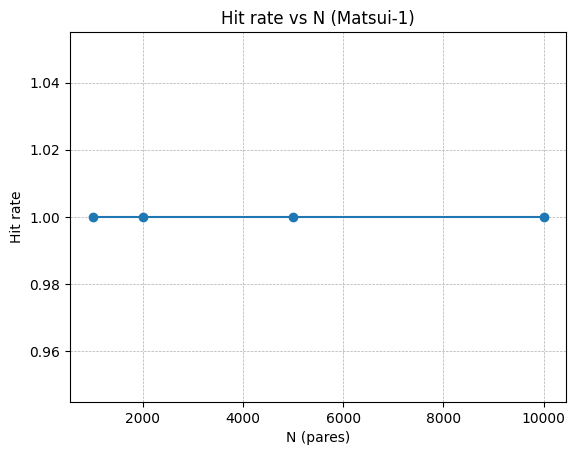

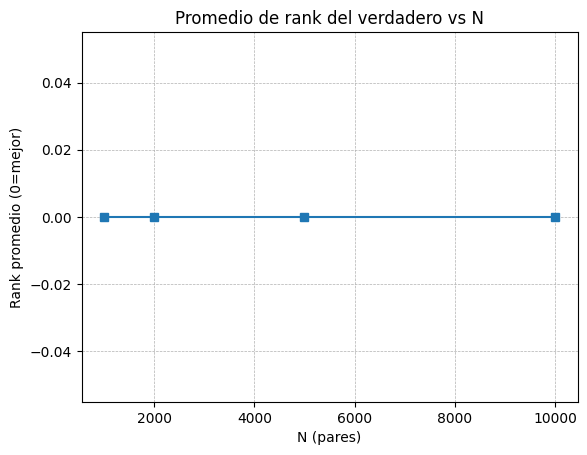

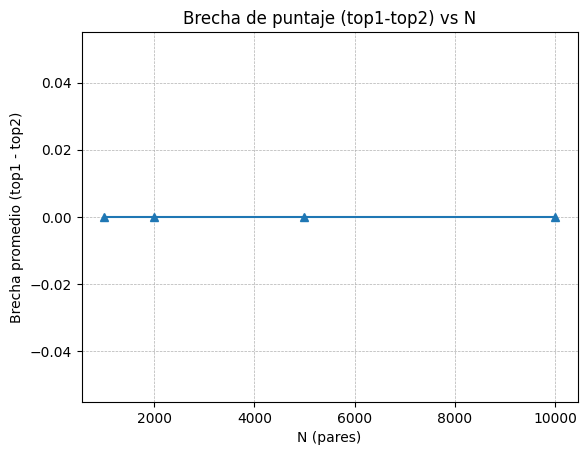

In [ ]:
metrics = sweep_pairs_and_eval(
    sp, GX0, GY0, r, w_last=w_last,
    Ns=(1000, 2000, 5000, 10000), trials=5,
    build_trail_mode="greedy"
)

# Guardar y mostrar figuras
df, paths = save_all_plots(metrics, prefix="tesis_matsui_speck32_r6")
display(df)
